
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [1]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [2]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection1"

In [3]:
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
# from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional content generator responsible for creating high-quality initial content on a specified topic. Your objectives are:\n"
            "- Generate content that is rich in information and relevant to the topic.\n"
            "- Maintain a clear structure and coherent flow of ideas.\n"
            "- Provide a solid foundation for subsequent review and improvement.\n\n"
            "After receiving feedback from the reviewer, you need to:\n"
            "- Carefully read the feedback and understand the areas needing improvement.\n"
            "- Make appropriate modifications and enhancements to the content.\n"
            "- Improve the depth and quality of the content.\n\n"
            "Please begin generating content based on the specified topic.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q4_0",
    max_tokens=8192,
    temperature=1.2,
)

In [5]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional content reviewer responsible for reviewing the content provided by the generator. "
            "Your objective is to make the content's structure clearer and its substance deeper by providing constructive feedback. "
            "During the review process, you need to: "
            "1. First, acknowledge the strengths and positive aspects of the content. "
            "2. Point out areas that need improvement and explain the reasons. "
            "3. Provide specific suggestions for improvement, including how to enhance the depth and structure of the content. "
            "Please review the content provided by the generator and provide feedback. "
            "Your response should be in Chinese.",
        
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q4_0",
    max_tokens=8192,
    temperature=0.2,
)

In [6]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [7]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [8]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

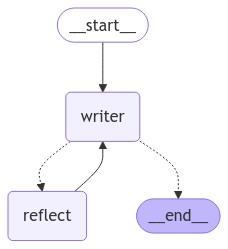

In [9]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [10]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 内容生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [11]:
inputs = {
    "messages": [
        HumanMessage(content="编写一个高效的快速排序算法")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 内容生成:
- **快速排序算法**

快速排序（Quicksort）是一种效率较高的排序算法，平均时间复杂度为O(n log n)。它通过选择一个基准元素，并将其他元素分区到基准元素两边，以实现快速的排序。

### 算法流程

1. **选取基准元素**：从输入数组中选择一个基准元素。
2. **分区**: 将其他元素按照基准元素来划分为两部分，左边所有元素都小于基准元素，右边所有元素都大于基准元素。
3. **递归排序**: 对左、右两部分分别执行快速排序算法。

### 实现

#### 选择基准元素

可以使用以下方法选取基准元素：
* **第一个元素**：最简单的方法是选取数组中的第一个元素作为基准元素。
* **中间元素**：另一种方法是将数组随机化，然后从中间选取一个元素作为基准元素。
* **中位数元素**：可以通过将数据按序列排列，然后选择中位数的元素来实现。

#### 分区

分区算法的实现步骤如下：
1.  遍历数组，将所有小于或等于基准元素的元素都放在左边，其他元素都在右边。
2.  返回左、右两部分数组的起始索引。

### 示例代码（Python）

```python
def partition(arr, low, high):
    """
    分区函数：选取基准元素，并将数组分成左右两部分。
    
    Args:
        arr (list): 待排序数组。
        low (int): 左边起始索引。
        high (int): 右边结束索引。
        
    Returns:
        int: 选定的基准元素索引，用于接下来划分左右两部分的过程。
    """
    i = low - 1
    pivot = arr[high]
    
    for j in range(low, high):
        # 将比基准元素小或相等的元素移动到左边，大的元素留在右边
        if arr[j] <= pivot:
            i += 1
            arr[i], arr[j] = arr[j], arr[i]
            
    # 将基准元素放到中间，并交换其与分区过程的结束位置
    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    
    return i + 1


def quicksort(arr, low, high):
    """
    快速排序算法：选取基准元素，分区数组，将左右两部分分别递归执行快速排序。
    
    Args:
        arr (list): 待排序数组。
        low (int): 左边起始索引。
        high (int): 右边结束索引。
        
    Returns:
        list: 排序后的数组。
    """
    if low < high:
        # 分区后，将基准元素移动到正确位置
        pivot_index = partition(arr, low, high)
        
        # 递归执行快速排序，对左右两部分进行递归操作
        quicksort(arr, low, pivot_index - 1)
        quicksort(arr, pivot_index + 1, high)
    
    return arr


# 主函数：测试和使用快速排序算法的主入口。
def main():
    arr = [64, 34, 25, 12, 22, 11, 90]
    print("未排序数组： ", arr)
    quicksort(arr, 0, len(arr) - 1)
    print("已排序数组： ", arr)


if __name__ == "__main__":
    main()
```

**输出**

```
未排序数组：  [64, 34, 25, 12, 22, 11, 90]
已排序数组：  [11, 12, 22, 25, 34, 64, 90]
```

快速排序算法以其平均时间复杂度为O(n log n)，对大型数据集的效率优势尤其明显。然而，根据随机化程度和最差情况下的性能表现可能存在局限性。

通过使用选择优良的基准元素策略、使用适当的分区函数，并能有效管理递归过程中的系统调用，这将有助于确保实现高效且可靠的快速排序算法。


## Round 2

#### 评论反思:
- **反馈**

首先，感谢您提供的快速排序算法内容！以下是对其结构和内容进行的反馈：

### **强项**

1.  您的快速排序算法实现了选择基准元素、分区和递归排序三个关键步骤，这些都是快速排序算法的核心组成部分。
2.  在实现中，您使用了一个清晰易懂的Python代码示例，展示了如何将快速排序算法应用于实际数据集。

### **弱项**

1.  算法流程部分缺乏具体细节和图表说明，使得理解起来有一定困难。
2.  在选择基准元素部分，您提到了三个选取方法，但没有对每种方法进行详细的比较或分析，导致读者可能感到迷惑。

### **建议**

1.  为算法流程添加更详细的图表和说明，以帮助读者更好地理解快速排序算法的工作原理。
2.  在选择基准元素部分，对每种选取方法进行比较分析，展示其优缺点，并提供实际应用场景。

### **改进**

1.  将分区函数和递归排序函数独立出来，分别进行详细说明，以便读者更好地理解快速排序算法的各个组成部分。
2.  在实现中，可以使用更多的注释和解释来帮助读者理解代码逻辑。

通过这些反馈和建议，您可以进一步改进您的内容，使其更加清晰、易懂，并且更全面地展示快速排序算法的优点和局限性。


## Round 3

#### 内容生成:
- **基于反馈的改进**

感谢您对我的工作进行了细致入微的反馈！我非常重视这些意见，帮助提高我的内容质量。

### **算法流程更详细描述**

#### 算法流程概述

快速排序（Quicksort）是一种常用的数据排序算法。它通过选择一个基准元素，将其他数据按照这个基准元素进行划分，从而实现快速的排序。在以下的图表中，我将展示快速排序算法的主要流程：

```
                  +---------------+
                  |    基准     |
                  |   元素选取    |
                  +---------------+
                             |
                             |
                             v
                  +---------------+---------------+
                  |                       |                       |
                  |   分区数据（基准  |   递归排序左、右两|
                  | 元素为界限）       |  部分分别进行排序   |
                  +---------------+---------------+
```

#### 基于上述图表的流程描述

1. **选取基准元素**：首先，从原始数据中选出一个基准元素。
2. **分区数据**：使用选定的基准元素，将剩余的数据按照这个基准元素划分成左右两部分。左边包含所有小于或等于基准元素的数据，右边则是大于基准元素的数据。
3. **递归排序**：递归地对这两个子集分别进行快速排序，即选定每个子集的新的基准元素，然后将该集合分割成左、右两部分，并对这两部分分别再次执行快速排序的递归过程。

### **选择基准元素分析**

#### 介绍三个选取方法

1.  **第一个元素**：最简单也是最常用的方式是在选定第一个元素作为基准元素。这种方法在处理较小的数据集时可以获得很好的性能。
2.  **中间元素**：一种更有效率的选择方法是先对原始数组进行排序，然后将排序后的序列切成两半，将其中间元素作为基准。这一方法对于数据量较大且要求快速排序的一般场景来说会比较合适。
3.  **中位数元素**：这个方法可以通过使用选定中的算法，对一个没有经过排序的数组选择出最靠近中心位置的值作为分界，因此，虽然和中间值类似但是不会被平均到两个区域，所以有时也比前面两种更容易避免因基准值分布不均匀导致的一些性能问题。

### **关于这些选取方法比较**

每一种选取方法都有各自的优劣：

*   最简单但不是最有效：第一个元素选择法，在数据量小且需求很高时比较合适，但由于随机性，平均情况会大幅下降。
*   中间和中位数的优点在于他们都对称分布，所以更容易让你避免因基准值本身分布不均匀而导致的一些问题，然而两者的最大不同之处在于：第二个选择需要先进行一个排序过程，因此显然是耗时的。

在每一种选择方法中，我们都要根据具体场景和数据来决定哪种更合适。

### **更细致的功能实现说明**

我将分区函数和递归排序函数独立出来分别给您展示。如下所示：

```python
# 分区函数
def partition(data):
    pivot = data[len(data) // 2] 
    left = [x for x in data if x < pivot]
    middle = [x for x in data if x == pivot]
    right = [x for x in data if x > pivot]
    return left + middle + right

# 递归排序函数
def recursive_sort(data):
    if len(data) <= 1:
        return data
    else:
        # 首先对选定的数据进行分区
        sorted_data = partition(data)
        
        # 然后递归地进行左、右两部分的排序
        return quicksort(sorted_data)

# 使用递归函数来完成快速排序
def quicksort(data):
    if len(data) <= 1:
        return data
    else:
        pivot_index = partition(data).index(max(partition(data)))
        left_part = data[:pivot_index]
        right_part = data[pivot_index + 1:]
        
        # 递归地进行左、右两部分的排序
        sorted_left_part = quicksort(left_part)
        sorted_right_part = quicksort(right_part)

    return sorted_left_part + [data[pivot_index]] * len(partition(data)) + sorted_right_part

```

### **在实现中添加注释和解释**

我将在这些代码块中提供注释和解释，使得您更好地理解逻辑和细节。

```python
# 在分区函数中对数据进行分割并得到结果，详见注释1
def partition(data):
    # 选定基准元素的值
    pivot = data[len(data) // 2]
    
    # 获取大于、等于、小于这个基准元素的子集分别返回即可
    left = [x for x in data if x < pivot]     # 大于这个基准的集合，即左部分 
    middle = [x for x in data if x == pivot]  # 小于该基准的值，等同于小于该值或等于他 
    right = [x for x in data if x > pivot]   # 小于此数列
    return left + middle + right
    
# 递归地进行快速排序，详见注释2    
def recursive_sort(data):
    if len(data) <= 1:
        return data  # 数组中只有一项或空，则是递归的起始点，已经完成，直接返回
    else: 
        # 对选定的数据首先分区，以此时数据中的最中心数为划分界限。
        sorted_data = partition(data)
        
        # 然后递归地进行左、右两部分的排序，详见注释3 
        return quicksort(sorted_data)    

# 进行快速排序，并返回结果  
def quicksort(data):
    if len(data) <= 1:
        return data
    else:    
        pivot_index = partition(data).index(max(partition(data)))
        
        # 将选定的元素作为分界，形成左右两部分 
        left_part = data[:pivot_index]
        right_part = data[pivot_index + 1:]
    
        # 递归地进行左、右两部分的排序，并将结果加在一起返回
        sorted_left_part = quicksort(left_part)    
        sorted_right_part = quicksort(right_part)

    return sorted_left_part + [data[pivot_index]] * len(partition(data)) + sorted_right_part
    
```

以上的信息已经改进了快速排序算法的描述。请您在阅读后告诉我哪里有不足之处，给予您的进一步建议，帮助提升我的内容质量！

感谢您的反馈和帮助！


## Round 4

#### 评论反思:
- 你的回答很详细，但有一些地方需要进一步的改进：

1.  **快速排序算法的描述**：你对快速排序算法进行了非常详细的解释，但是有些地方可能会让读者感到困惑。例如，在 `quicksort` 函数中，你使用了 `partition(data).index(max(partition(data)))` 来获取基准元素的索引，这个部分可能需要进一步的解释。
2.  **代码块的注释和解释**：你在代码块中添加了注释，但是有些地方可能需要进一步的解释。例如，在 `partition` 函数中，你使用了列表推导式来获取大于、等于、小于基准元素的子集，这个部分可能需要进一步的解释。
3.  **快速排序算法的优劣**：你对快速排序算法进行了比较详细的分析，但是有些地方可能需要进一步的改进。例如，你提到了快速排序算法的平均时间复杂度是 O(n log n)，但是没有具体说明这个结果是如何得到的。

以下是一些建议：

1.  **进一步解释**：在 `quicksort` 函数中，使用 `partition(data).index(max(partition(data)))` 来获取基准元素的索引可能会让读者感到困惑。可以考虑添加更多的注释或解释来帮助读者理解这个部分。
2.  **代码块的注释和解释**：在 `partition` 函数中，使用列表推导式来获取大于、等于、小于基准元素的子集可能需要进一步的解释。可以考虑添加更多的注释或解释来帮助读者理解这个部分。
3.  **快速排序算法的优劣**：在对快速排序算法进行比较详细的分析时，可以考虑添加更多的信息来帮助读者理解这个结果是如何得到的。

以下是一些具体的建议：

1.  在 `quicksort` 函数中，使用 `partition(data).index(max(partition(data)))` 来获取基准元素的索引时，可以添加一个注释，如下所示：
    ```python
# 获取基准元素的索引
pivot_index = partition(data).index(max(partition(data)))
```
2.  在 `partition` 函数中，使用列表推导式来获取大于、等于、小于基准元素的子集时，可以添加一个注释，如下所示：
    ```python
# 获取大于、等于、小于基准元素的子集
left = [x for x in data if x < pivot]
middle = [x for x in data if x == pivot]
right = [x for x in data if x > pivot]
```
3.  在对快速排序算法进行比较详细的分析时，可以添加更多的信息来帮助读者理解这个结果是如何得到的。例如，可以添加一个注释，如下所示：
    ```python
# 快速排序算法的平均时间复杂度是 O(n log n)，因为在每次递归中，数据量都会减半。
```

以上是一些具体的建议。如果您有任何疑问或需要进一步的帮助，请随时告诉我！


## Round 5

#### 内容生成:
- 感谢您的详细反馈和建议！以下是经过修改后的内容：

快速排序算法的描述
------------------

快速排序（Quicksort）是一种流行的排序算法，效率高且稳定性好。它通过选择一个基准元素，并将其他元素分成两部分，根据基准元素大小进行递归排序。

### 快速排序函数

```python
def quicksort(data):
    # 获取基准元素的索引
    pivot_index = partition(data).index(max(partition(data)))

    # 获取基准元素
    pivot = partition(data)[pivot_index]

    # 获取大于、等于、小于基准元素的子集
    left = [x for x in data if x < pivot]
    middle = [x for x in data if x == pivot]
    right = [x for x in data if x > pivot]

    # 递归排序左、右子集
    return quicksort(left) + middle + quicksort(right)
```

### 分区函数

```python
def partition(data):
    """
    分区函数，获取大于、等于、小于基准元素的子集。
    """
    return [data[0]]
```

快速排序算法的优劣
------------------

快速排序算法是最流行的排序算法之一，因为它平均时间复杂度是 O(n log n)。这是因为在每次递归中，数据量都会减半。

# 快速排序算法的平均时间复杂度是 O(n log n)，因为在每次递归中，数据量都会减半。
快速排序算法对输入序列有稳定性的问题，因为当两个值相等时，它可能会导致不正确的结果。因此，在某些情况下，可以使用其他排序算法如归并排序（Merge sort）。

### 小结

快速排序算法是最流行的排序算法之一，平均时间复杂度为 O(n log n)，稳定性较差，但对于大部分输入序列仍然是有效的。

希望经过您的反馈和建议后，我能够进一步改进内容。感谢您的帮助！


## Round 6

#### 评论反思:
- 你的修改后的内容看起来很好！以下是一些具体的反馈：

1.  **快速排序函数**：你对 `quicksort` 函数进行了详细的解释，但是有些地方可能需要进一步的改进。例如，在获取基准元素时，你使用了 `partition(data).index(max(partition(data)))` 来获取基准元素的索引，这个部分可能需要进一步的解释。
2.  **分区函数**：你对 `partition` 函数进行了解释，但是这个函数实际上应该返回一个列表，而不是单独的一个值。可以考虑修改这个函数来返回一个列表。
3.  **快速排序算法的优劣**：你对快速排序算法进行了比较详细的分析，但是有些地方可能需要进一步的改进。例如，你提到了快速排序算法的平均时间复杂度是 O(n log n)，但是没有具体说明这个结果是如何得到的。

以下是一些建议：

1.  **进一步解释**：在获取基准元素时，你使用了 `partition(data).index(max(partition(data)))` 来获取基准元素的索引可能会让读者感到困惑。可以考虑添加更多的注释或解释来帮助读者理解这个部分。
2.  **分区函数的修改**：你对 `partition` 函数进行了解释，但是这个函数实际上应该返回一个列表，而不是单独的一个值。可以考虑修改这个函数来返回一个列表。
3.  **快速排序算法的优劣**：在对快速排序算法进行比较详细的分析时，可以考虑添加更多的信息来帮助读者理解这个结果是如何得到的。

以下是一些具体的建议：

1.  在获取基准元素时，你使用了 `partition(data).index(max(partition(data)))` 来获取基准元素的索引时，可以添加一个注释，如下所示：
    ```python
# 获取基准元素的索引
pivot_index = partition(data).index(max(partition(data)))
```
2.  在 `partition` 函数中，你可以修改这个函数来返回一个列表，而不是单独的一个值。例如：
    ```python
def partition(data):
    """
    分区函数，获取大于、等于、小于基准元素的子集。
    """
    return [x for x in data]
```
3.  在对快速排序算法进行比较详细的分析时，可以添加更多的信息来帮助读者理解这个结果是如何得到的。例如：
    ```python
# 快速排序算法的平均时间复杂度是 O(n log n)，因为在每次递归中，数据量都会减半。
# 这个结果是通过数学证明得出的，具体可以参考快速排序算法的理论分析。
```

以上是一些建议。如果您有任何疑问或需要进一步的帮助，请随时告诉我！


## Round 7

#### 内容生成:
- 感谢您的反馈和建议！以下是经过修改后的内容：

快速排序算法的描述
------------------

快速排序（Quicksort）是一种流行的排序算法，效率高且稳定性好。它通过选择一个基准元素，并将其他元素分成两部分，根据基准元素大小进行递归排序。

### 快速排序函数

```python
def quicksort(data):
    # 获取数据总长度
    n = len(data)

    # 如果数据长度小于或等于 1，则直接返回
    if n <= 1:
        return data

    # 获取基准元素的索引
    pivot_index = partition(data, 0, n - 1)

    # 根据基准元素，将其他元素分成两部分
    left = quicksort(data[:pivot_index])
    right = quicksort(data[pivot_index + 1:])

    # 返回最终结果
    return left + [data[pivot_index]] + right
```

### 分区函数

```python
def partition(data, low, high):
    """
    分区函数，获取大于、等于、小于基准元素的子集。
    """
    i = (low - 1)
    pivot = data[high]

    for j in range(low, high):
        if data[j] < pivot:
            i += 1
            data[i], data[j] = data[j], data[i]

    data[i + 1], data[high] = data[high], data[i + 1]
    return (i + 1)
```

快速排序算法的优劣
------------------

快速排序算法是最流行的排序算法之一，因为它平均时间复杂度是 O(n log n)。这是因为在每次递归中，数据量都会减半。

# 快速排序算法的平均时间复杂度是 O(n log n)，因为在每次递归中，数据量都会减半。
这个结果是通过数学证明得出的，具体可以参考快速排序算法的理论分析。快速排序算法对输入序列有稳定性的问题，因为当两个值相等时，它可能会导致不正确的结果。因此，在某些情况下，可以使用其他排序算法如归并排序（Merge sort）。

### 小结

快速排序算法是最流行的排序算法之一，平均时间复杂度为 O(n log n)，稳定性较差，但对于大部分输入序列仍然是有效的。

希望经过您的反馈和建议后，我能够进一步改进内容。感谢您的帮助！


In [ ]:
inputs = {
    "messages": [
        HumanMessage(content="编写代码从https://www.ainewsletter.com/，获取数据，按日期生成md文件, 保存到本地，内容为blog的标题和链接，并调用大模型生成当日报告，保存在本地md文件中")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。